In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from numba import jit, prange
import h5py
import seaborn as sns
import ast
from matplotlib import rcParams
rcParams['font.family'] = "serif"     
rcParams['font.size'] = 12


def initialize_particles(n, radius):
    """ Initialize particles at edge of disc. """
    angles = np.random.uniform(0, 2 * np.pi, n)
    radii = radius 
    x = radii * np.cos(angles)
    y = radii * np.sin(angles)
    return np.column_stack((x, y))

@jit(nopython=True)
def initialize_particles_center_bias(n, radius, center_bias=0.3):
    angles = np.random.rand(n) * 2 * np.pi
    radii = radius * np.sqrt(np.random.rand(n) * center_bias)
    x = radii * np.cos(angles)
    y = radii * np.sin(angles)
    particles = np.empty((n, 2))
    for i in prange(n):
        particles[i, 0] = x[i]
        particles[i, 1] = y[i]
    return particles

@jit(nopython=True)
def compute_forces_and_energy_vectorized(particles):
    n = len(particles)
    # Initialize matrices
    diff = np.empty((n, n, 2))
    distances = np.empty((n, n))
    forces = np.zeros((n, 2))

    # Calculate distance vectors between particles
    for i in range(n):
        for j in range(n):
            diff[i, j, 0] = particles[i, 0] - particles[j, 0]
            diff[i, j, 1] = particles[i, 1] - particles[j, 1]
            distances[i, j] = np.sqrt(diff[i, j, 0]**2 + diff[i, j, 1]**2)

    # Avoid division by zero
    for i in range(n):
        distances[i, i] = np.inf

    # Calculate total energy and forces
    energy = 0.0
    for i in range(n):
        for j in range(i+1, n):
            energy += 1 / distances[i, j]
        for k in range(n):
            if i != k:
                factor = 1 / (distances[i, k] ** 3)
                forces[i, 0] += diff[i, k, 0] * factor
                forces[i, 1] += diff[i, k, 1] * factor

    return forces, energy


@jit(nopython=True)
def update_particle_positions_force_bias(particles, step_size, radius, forces, index, alpha=1, beta=0.1):
    force = forces[index]

    # Calculate forces on particle and generate random component of direction for next step
    force_angle = np.arctan2(force[1], force[0])
    random_angle = np.random.uniform(0, 2 * np.pi)

    # Calculate next step based on force + random
    tot_angle = alpha * force_angle + beta * random_angle
    direction = np.array([np.cos(tot_angle), np.sin(tot_angle)])

    # Update particle position and check radius
    new_particle = particles[index] + direction * step_size
    distance_from_center = np.sqrt(new_particle[0]**2 + new_particle[1]**2)
    
    # If step relocates to outside of circle, reposition on boundary
    if distance_from_center > radius:
        new_particle = new_particle / distance_from_center * radius

    return new_particle

@jit(nopython=True)
def simulate_charged_particles_individual_steps(n, radius, steps, initial_step_size, final_step_size, initial_temp, final_temp, markov_chain=100, cooling=False, alpha=1, beta=0.1):
    """ Simulate the charged particles with simulated annealing, checking each individual particle move. """
    
    particles = initialize_particles_center_bias(n, radius)
   
    min_energy_config = None
    min_energy = np.inf
    energies = []

    temperature = initial_temp
    step_size = initial_step_size


    # Calculate the cooling and step size rates
    step_rate = (final_step_size / initial_step_size) ** (1 / steps)

    acceptance_rates = []  # Track acceptance rate
    step_sizes = []  # Track step size
    accepted_moves = 0
    step_sizes.append(step_size)
    for step in range(steps):
        
        for i in range(n):
            forces, current_energy = compute_forces_and_energy_vectorized(particles)

            # Try moving one particle
            new_particles = particles.copy()
            new_particles[i] = update_particle_positions_force_bias(particles, step_size, radius, forces, i, alpha, beta)
            new_energy = compute_forces_and_energy_vectorized(new_particles)[1]

            # Decide whether to accept the new position for this particle
            if new_energy < current_energy or np.random.rand() < np.exp((current_energy - new_energy) / temperature):
                particles[i] = new_particles[i]
                accepted_moves += 1

        # Update energy, temperature, and step size after each step
        energy = compute_forces_and_energy_vectorized(particles)[1]
        energies.append(energy)
        
        # lower temperature after every markov chain
        if (step + 1) % markov_chain == 0:
            if not cooling:
                cooling_rate = (final_temp / initial_temp) ** (markov_chain / steps)
                temperature*=cooling_rate
            elif cooling == 'exp':
                temperature*=0.9
            elif cooling == 'linear':
                temperature = initial_temp - step*(initial_temp-final_temp)/(steps)

            acceptance_rate = accepted_moves / (n * markov_chain)
            acceptance_rates.append(acceptance_rate)
            accepted_moves = 0  # Reset count for the next batch
            
        if energy < min_energy:
            min_energy = energy
            min_energy_config = particles.copy()

        
        step_size *= step_rate
        step_sizes.append(step_size)
    return min_energy_config, min_energy, energies, step_sizes, acceptance_rates

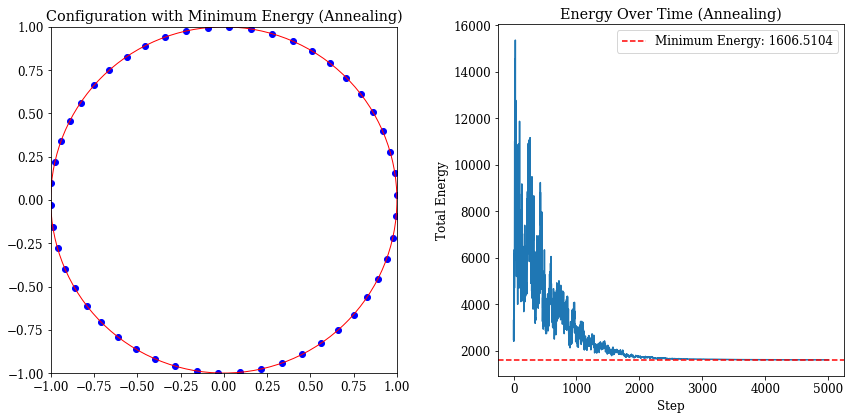

In [6]:
# Parameters
n_particles = 50
circle_radius = 1
markov_chain = 100
simulation_steps = 50 * markov_chain
initial_step_size = 1
final_step_size = 0.02
final_temperature = 0.001
initial_temperature = 20*n_particles

# Run the simulation with simulated annealing
annealing_particles, annealing_min_energy, annealing_energy_over_time, step_sizes, acceptance_rates = simulate_charged_particles_individual_steps(
    n_particles, circle_radius, simulation_steps, initial_step_size, final_step_size, initial_temperature, final_temperature, markov_chain=markov_chain, beta=0
)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Configuration with minimum energy (annealing)
circle = plt.Circle((0, 0), circle_radius, color='r', fill=False)
ax[0].add_artist(circle)
ax[0].scatter(annealing_particles[:, 0], annealing_particles[:, 1], color='blue')
ax[0].set_xlim([-circle_radius, circle_radius])
ax[0].set_ylim([-circle_radius, circle_radius])
ax[0].set_title("Configuration with Minimum Energy (Annealing)")
ax[0].set_aspect('equal', 'box')

# Energy over time (annealing)
ax[1].plot(annealing_energy_over_time)
ax[1].set_title("Energy Over Time (Annealing)")
ax[1].set_xlabel("Step")
ax[1].set_ylabel("Total Energy")
ax[1].axhline(y=annealing_min_energy, color='r', linestyle='--', label=f'Minimum Energy: {annealing_min_energy:.4f}')
ax[1].legend()

plt.tight_layout()

0 0.9615269172193879 870.9635899560806
1000 1.0107918386311034 218.77616239495512
2000 0.865050208266505 54.9540873857624
3000 0.9777755597183405 13.803842646028825
4000 0.5827868012174522 3.467368504525308
5000 0.8398028140064272 0.8709635899560783
6000 0.19271828160541024 0.2187761623949545
7000 0.7300850260677689 0.05495408738576224
8000 2.0200393879714973 0.013803842646028784
9000 0.060082703344931654 0.003467368504525297


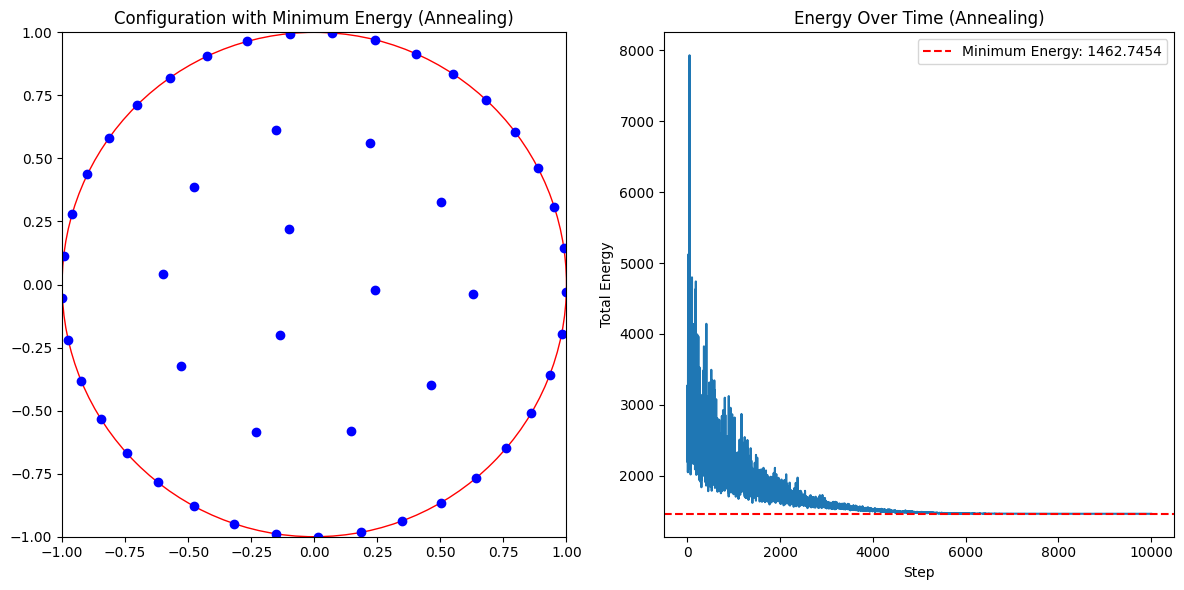

In [ ]:
n_particles = 50 
circle_radius = 1
markov_chain = 100
simulation_steps = 50*markov_chain
initial_step_size = 1
final_step_size = 0.02
initial_temperature = 20*n_particles
final_temperature = 0.001


# Run the simulation with simulated annealing
annealing_particles, annealing_min_energy, annealing_energy_over_time, step_sizes, acceptance_rates = simulate_charged_particles_individual_steps(
    n_particles, circle_radius, simulation_steps, initial_step_size, final_step_size, initial_temperature, final_temperature
)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Configuration with minimum energy (annealing)
circle = plt.Circle((0, 0), circle_radius, color='r', fill=False)
ax[0].add_artist(circle)
ax[0].scatter(annealing_particles[:, 0], annealing_particles[:, 1], color='blue')
ax[0].set_xlim([-circle_radius, circle_radius])
ax[0].set_ylim([-circle_radius, circle_radius])
ax[0].set_title("Configuration with Minimum Energy (Annealing)")
ax[0].set_aspect('equal', 'box')

# Energy over time (annealing)
ax[1].plot(annealing_energy_over_time)
ax[1].set_title("Energy Over Time (Annealing)")
ax[1].set_xlabel("Step")
ax[1].set_ylabel("Total Energy")
ax[1].axhline(y=annealing_min_energy, color='r', linestyle='--', label=f'Minimum Energy: {annealing_min_energy:.4f}')
ax[1].legend()

plt.tight_layout()

0 0.966416025368237 460
1000 1.1397327484404882 33.90051261945959
2000 0.6938772778600106 2.4983581649176956
3000 0.25509589676651206 0.18412091847330947
4000 0.9456737231637261 0.013569116348284598


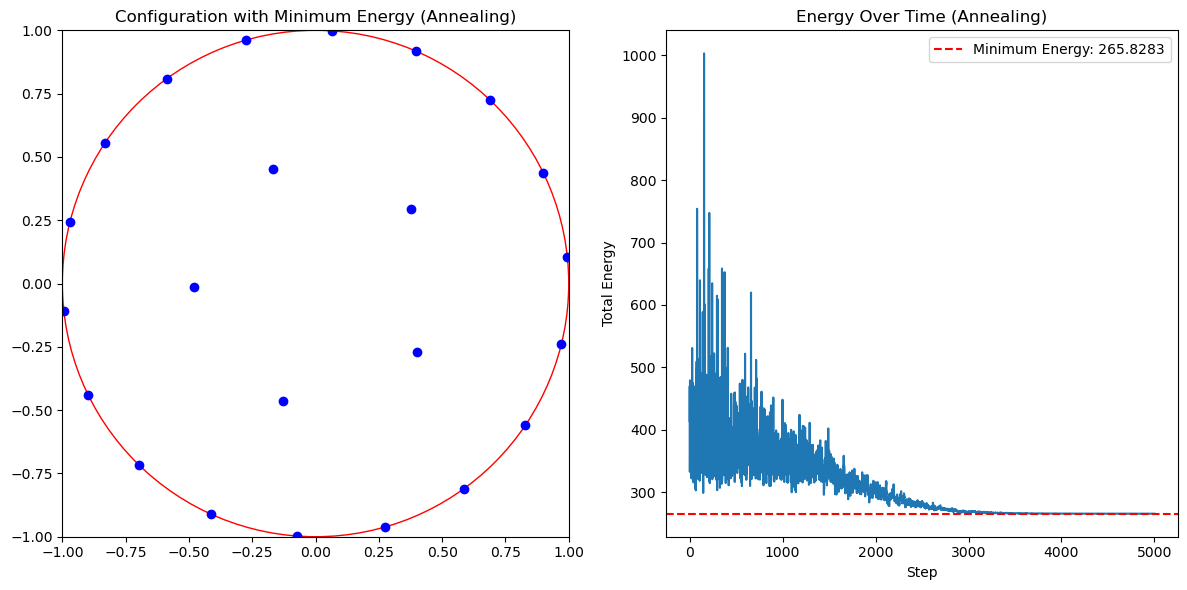

In [ ]:
# Parameters
n_particles = 23 
circle_radius = 1
markov_chain = 100
simulation_steps = 50*markov_chain
initial_step_size = 1
final_step_size = 0.02
initial_temperature = 20*n_particles
final_temperature = 0.001


# Run the simulation with simulated annealing
annealing_particles, annealing_min_energy, annealing_energy_over_time, step_sizes, acceptance_rates = simulate_charged_particles_individual_steps(
    n_particles, circle_radius, simulation_steps, initial_step_size, final_step_size, initial_temperature, final_temperature
)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Configuration with minimum energy (annealing)
circle = plt.Circle((0, 0), circle_radius, color='r', fill=False)
ax[0].add_artist(circle)
ax[0].scatter(annealing_particles[:, 0], annealing_particles[:, 1], color='blue')
ax[0].set_xlim([-circle_radius, circle_radius])
ax[0].set_ylim([-circle_radius, circle_radius])
ax[0].set_title("Configuration with Minimum Energy (Annealing)")
ax[0].set_aspect('equal', 'box')

# Energy over time (annealing)
ax[1].plot(annealing_energy_over_time)
ax[1].set_title("Energy Over Time (Annealing)")
ax[1].set_xlabel("Step")
ax[1].set_ylabel("Total Energy")
ax[1].axhline(y=annealing_min_energy, color='r', linestyle='--', label=f'Minimum Energy: {annealing_min_energy:.4f}')
ax[1].legend()

plt.tight_layout()
plt.show()

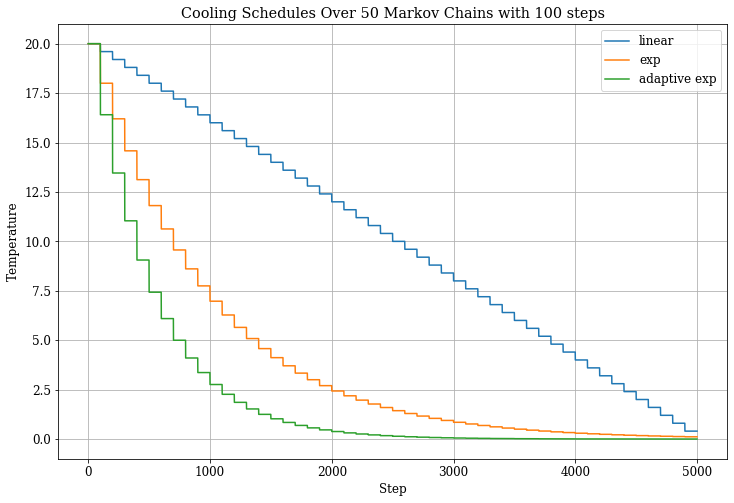

In [25]:
cooling_schedules = ['linear', 'exp', 'none']  # Updated False as a string for consistency
particle_counts = [26] # Particle count range
initial_temp = 20
final_temp = 0.001
steps = 5000
markov_chain = 100

# Reinitialize temperature arrays for all cooling schedules
temperatures = {schedule: [] for schedule in cooling_schedules}
exp_temp = 20
# Recalculate temperatures for each cooling schedule with correct initialization
for step in range(steps):
    # Linear cooling with temperature change at each markov_chain interval
    if step % markov_chain == 0:
        linear_temp = initial_temp - step * (initial_temp - final_temp) / steps
    temperatures['linear'].append(linear_temp)

    # Exponential cooling
    if step % markov_chain == 0 and step != 0:
        exp_temp *= 0.9
    temperatures['exp'].append(exp_temp)

    # No cooling (adaptive exponential) with temperature change at each markov_chain interval
    if step % markov_chain == 0:
        if step == 0:
            none_temp = initial_temp
        else:
            none_temp *= (final_temp / initial_temp) ** (markov_chain / steps)
    temperatures['none'].append(none_temp)

# Plot the temperatures
plt.figure(figsize=(12, 8))
for schedule in cooling_schedules:
    if schedule == 'none':
        plt.plot(temperatures[schedule], label="adaptive exp")
    else:
        plt.plot(temperatures[schedule], label=schedule)

plt.title('Cooling Schedules Over 50 Markov Chains with 100 steps') 
plt.xlabel('Step')
plt.ylabel('Temperature')
plt.legend()
plt.grid(True)
plt.show()

### Data generation cooling schedules

In [3]:
# Parameters
circle_radius = 1
markov_chain = 100
simulation_steps = 50 * markov_chain
initial_step_size = 1
final_step_size = 0.02
final_temperature = 0.001

cooling = ['linear', 'exp', False]

for cooling_schedule in cooling:
    # List to collect results metadata
    results_metadata = []
    # Create an HDF5 file

    with h5py.File(f'simulation_results_{cooling_schedule}.hdf5', 'w') as hdf_file:
        # Iterate over the specified number of particles
        for i, n_particles in enumerate(range(11, 27)):
            print(f"Running simulation for {cooling_schedule}/{n_particles} particles...")
            initial_temperature = 20 * n_particles

            for simulation in range(200):  # 100 simulations per particle count
                
                annealing_particles, annealing_min_energy, annealing_energy_over_time, step_sizes, acceptance_rates = simulate_charged_particles_individual_steps(
                n_particles, circle_radius, simulation_steps, initial_step_size, final_step_size, initial_temperature, final_temperature, markov_chain=markov_chain, cooling=cooling_schedule
            )
                # Save particle positions to HDF5
                dataset_name = f'Particles_{n_particles}_Sim_{simulation}'
                hdf_file.create_dataset(dataset_name, data=np.array(annealing_particles))

                # Collect metadata
                results_metadata.append({
                    'Particle_Count': n_particles,
                    'Simulation_Number': simulation,
                    'Min_Energy': annealing_min_energy,
                    'Positions_Dataset': dataset_name,
                    'Energy_Over_Time': annealing_energy_over_time,
                    'step_sizes': step_sizes,
                    'acceptance_rates': acceptance_rates  # Convert to list for storage
                })

    # Create DataFrame from metadata and save to CSV
    metadata_df = pd.DataFrame(results_metadata)
    metadata_df.to_csv(f'simulation_metadata_{cooling_schedule}.csv', index=False)



Running simulation for linear/11 particles...
Running simulation for linear/12 particles...
Running simulation for linear/13 particles...
Running simulation for linear/14 particles...
Running simulation for linear/15 particles...
Running simulation for linear/16 particles...
Running simulation for linear/17 particles...
Running simulation for linear/18 particles...
Running simulation for linear/19 particles...
Running simulation for linear/20 particles...
Running simulation for linear/21 particles...
Running simulation for linear/22 particles...
Running simulation for linear/23 particles...
Running simulation for linear/24 particles...
Running simulation for linear/25 particles...
Running simulation for linear/26 particles...
Running simulation for exp/11 particles...
Running simulation for exp/12 particles...
Running simulation for exp/13 particles...
Running simulation for exp/14 particles...
Running simulation for exp/15 particles...
Running simulation for exp/16 particles...
Runnin

#### Data processing

In [48]:
def process_data(metrics):
    # Iterate over each particle count
    data = {}
    for count in range(11, 26): 
        data[count] = {} 
    
        # Determine the min and max energy for this particle count across all cooling schedules
        min_energy, max_energy = float('inf'), float('-inf')

        for metric in metrics:
            # select cooling schedule and particles
            metadata_df = pd.read_csv(f'simulation_metadata_{metric}.csv')
            df_filtered = metadata_df[metadata_df['Particle_Count'] == count]
            # calculate min energies
            min_energies = df_filtered['Min_Energy']
            min_energy = min(min_energy, min_energies.min())
            max_energy = max(max_energy, min_energies.max())

            data[count][metric] = min_energies
        # Define the bin edges for this particle count
        print(count)
        bin_edges = np.linspace(min_energy, max_energy, 41) 
        data[count]['bins'] = bin_edges


    return data

In [53]:
cooling_schedules = ['linear', 'exp', False]
cooling_data = process_data(cooling_schedules)

11
12
13
14
15
16
17
18
19
20
21
22
23
24
25


#### Plotting

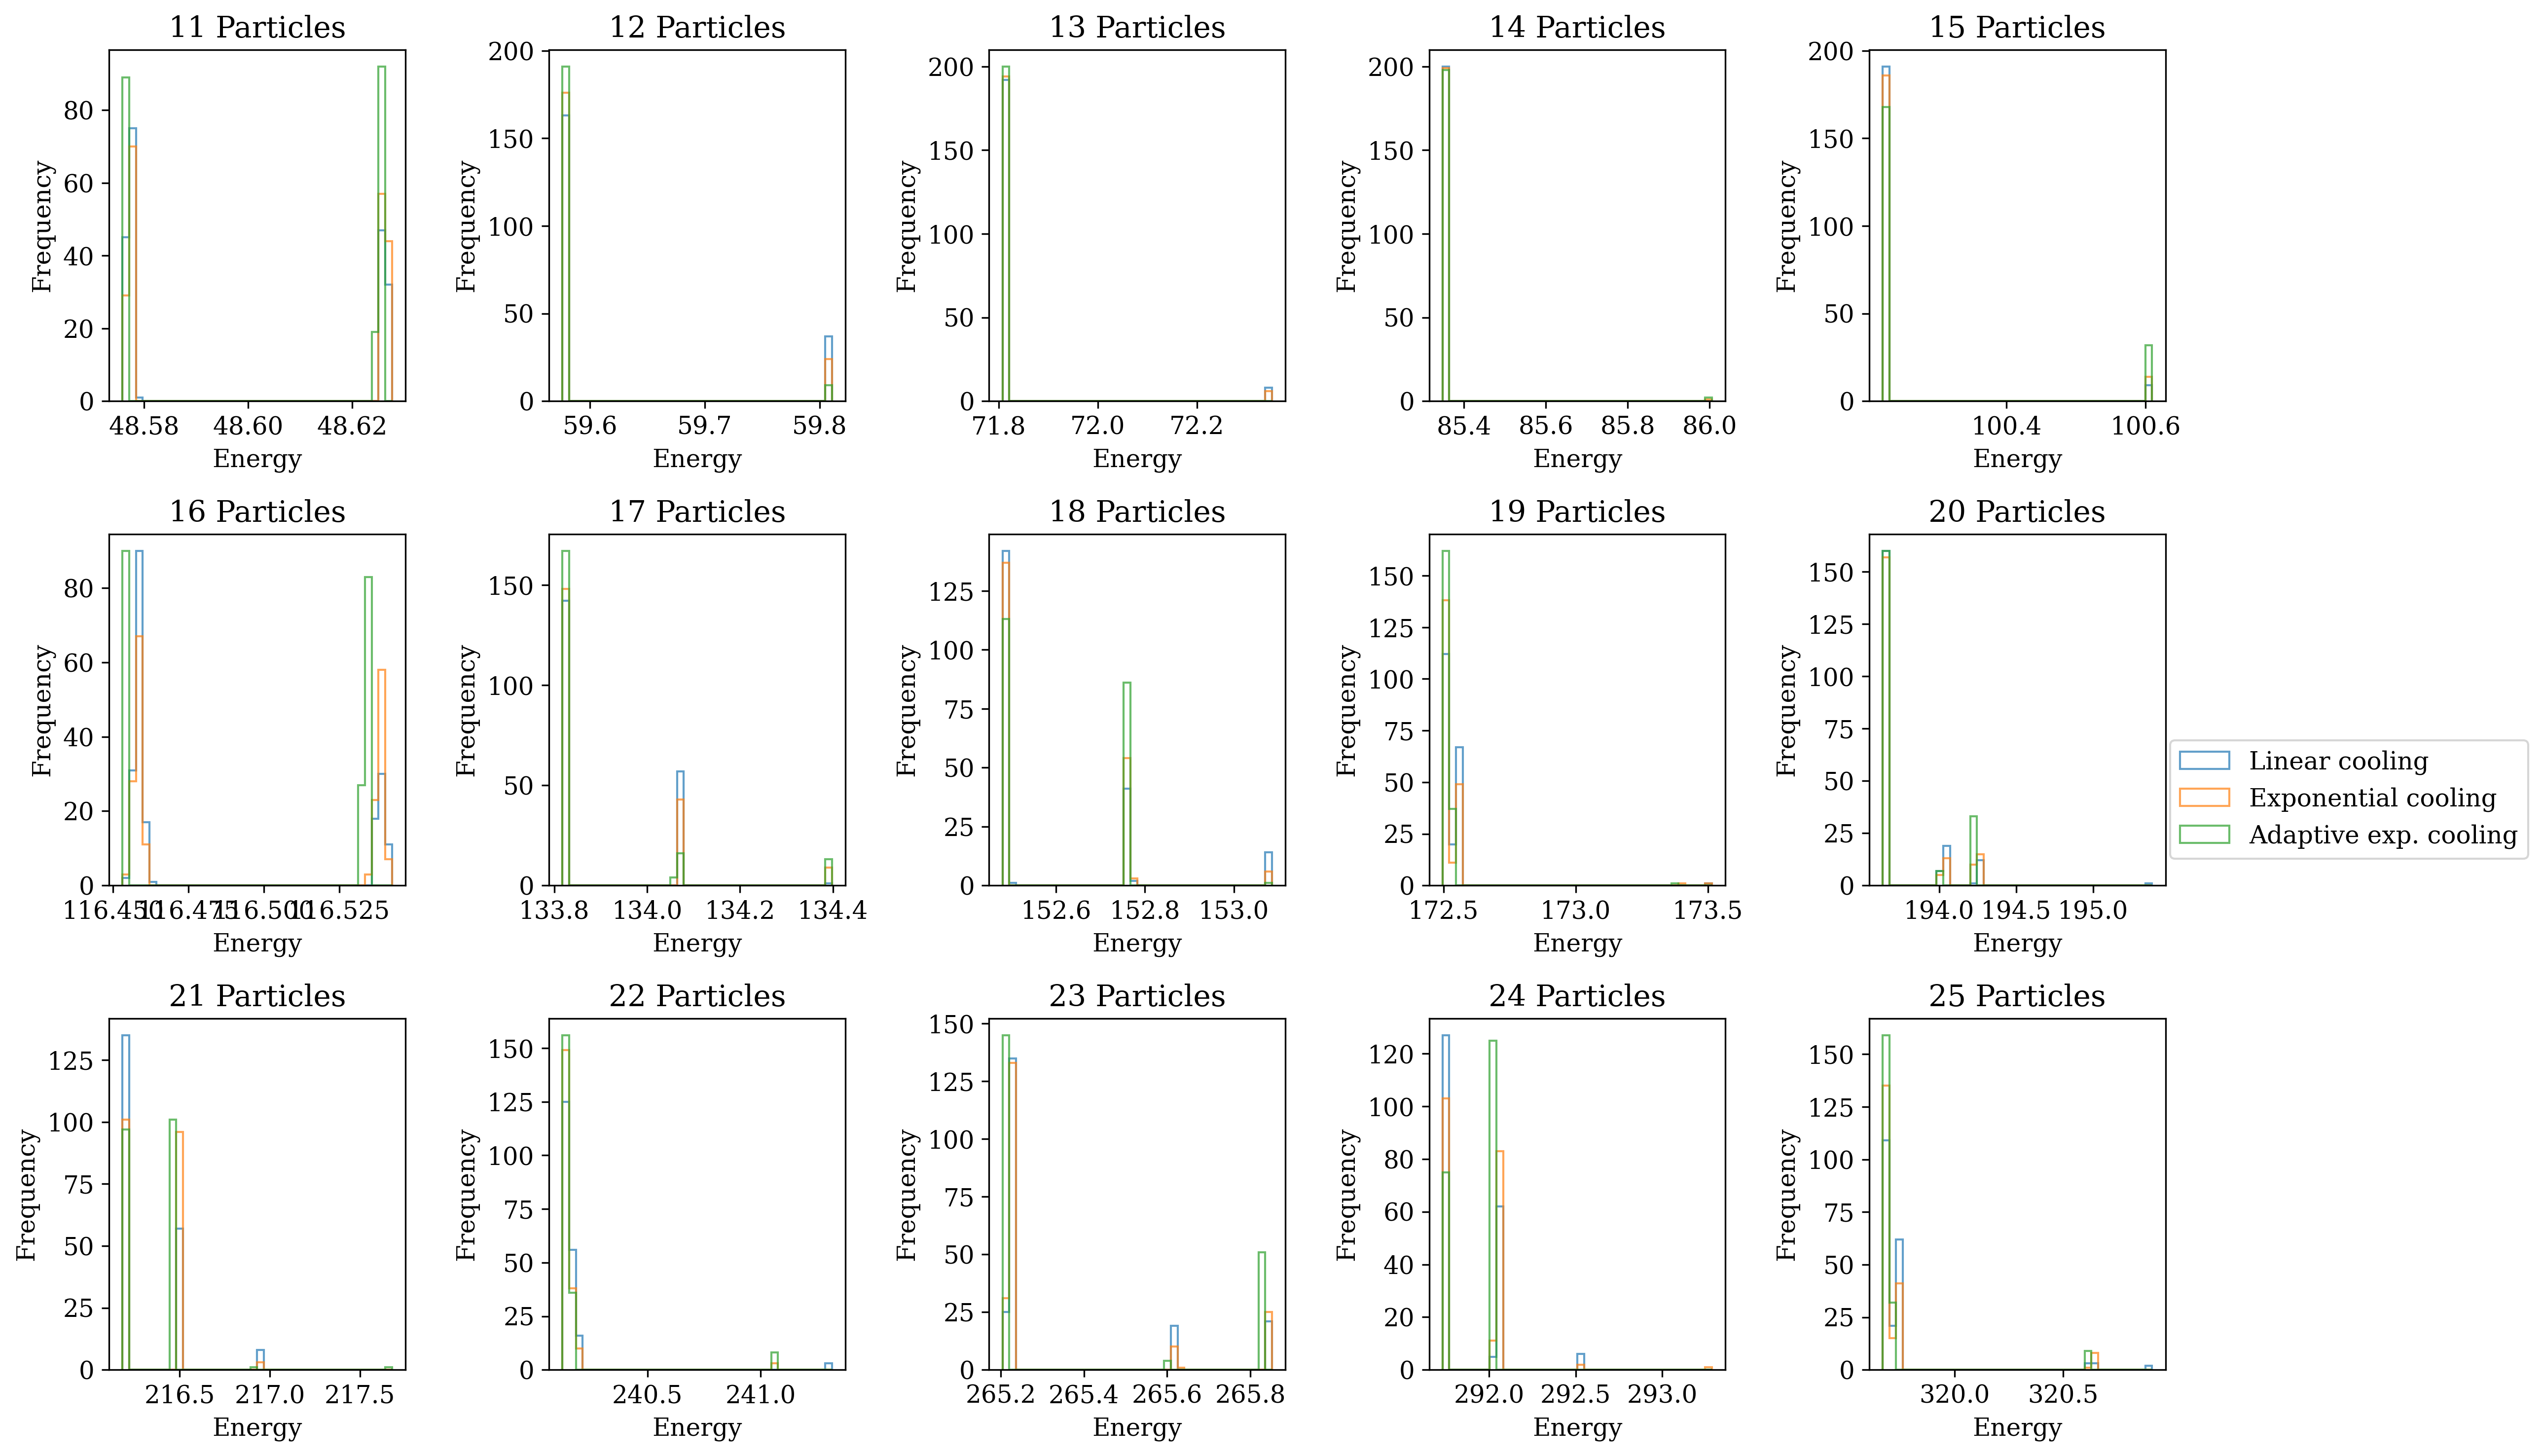

In [101]:
colors = sns.color_palette('tab10', len(cooling_schedules))  # Colors for different cooling schedules
nrows = 3 
ncols = 5  
x = 0
y = 0
loc = 0

cooling_names = ['Linear cooling', 'Exponential cooling', 'Adaptive exp. cooling']

fig, ax = plt.subplots(nrows, ncols,figsize=(15, 10), dpi=300)
for count in range(11,26):  
    for i, cooling_schedule in enumerate(cooling_schedules):
        # Plot histogram with customized bins and only outlines
        if count == 11:
            ax[y][x].hist(cooling_data[count][cooling_schedule], bins=cooling_data[count]['bins'], alpha=0.7, color=colors[i], label=cooling_names[i], histtype='step')
        else:
            ax[y][x].hist(cooling_data[count][cooling_schedule], bins=cooling_data[count]['bins'], alpha=0.7, color=colors[i], histtype='step')
        ax[y][x].set_title(f"{count} Particles")
        ax[y][x].set_xlabel('Energy')
        ax[y][x].set_ylabel('Frequency')
    
    # placement in grid
    loc +=1
    if loc%5 == 0:
        x = 0
        y+=1
    else: 
        x+=1

fig.legend(bbox_to_anchor=[1.15,0.5])
fig.tight_layout()

In [ ]:
cooling_schedules = ['linear', 'exp', 'Adaptive Exp']  # Updated False as a string for consistency
particle_counts = [26] # Particle count range
simulation_steps = 5000 # Define the number of simulation steps here

# Set up the plot
plt.figure(figsize=(15, 10))

# Process each cooling schedule
for cooling_schedule in cooling_schedules:
    # Load DataFrame from the metadata CSV file
    # Ensure the file naming convention matches the cooling_schedule values
    if cooling_schedule == 'Adaptive Exp':
        metadata_df = pd.read_csv(f'simulation_metadata_False.csv')
    else:
        metadata_df = pd.read_csv(f'simulation_metadata_{cooling_schedule}.csv')

    # Iterate over each particle count
    for n_particles in particle_counts:
        # Filter the DataFrame for the current particle count
        df_filtered = metadata_df[metadata_df['Particle_Count'] == n_particles]

        # Aggregate and average the acceptance rates
        total_acceptance_rates = np.zeros(simulation_steps)
        for index, row in df_filtered.iterrows():
            # Convert the string representation of the list to an actual list
            acceptance_rates_list = ast.literal_eval(row['Energy_Over_Time'])
            total_acceptance_rates += np.array(acceptance_rates_list, dtype=float)

        average_acceptance_rates = total_acceptance_rates / len(df_filtered)

        # Plot the average acceptance rates
        if cooling_schedule == 'Adaptive Exp':
            plt.plot(average_acceptance_rates, label=f'{n_particles} particles - adaptive exp')
        else:
            plt.plot(average_acceptance_rates, label=f'{n_particles} particles - {cooling_schedule}')



plt.title('Average Energy Over Time for 26 Particles (N=200)')
plt.xlabel('Step')
plt.yscale('log')
plt.ylabel('Average Energy')
# increase font size
plt.rcParams.update({'font.size': 18})
plt.legend()
plt.show()

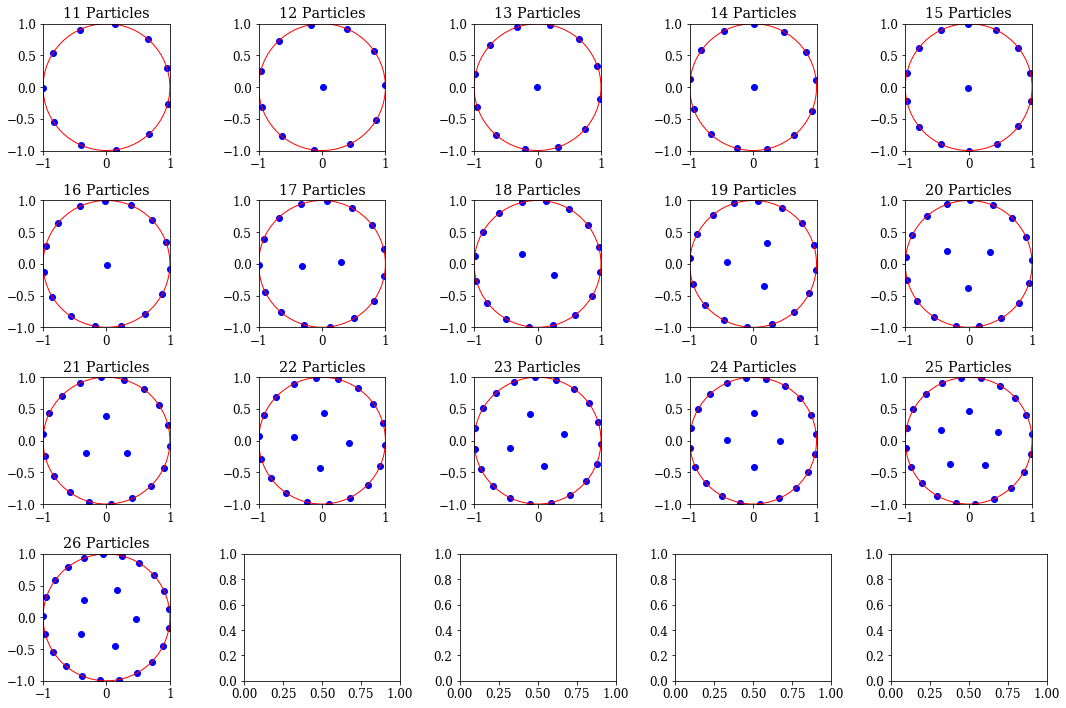

In [23]:
circle_radius = 1
# Load DataFrame from the metadata CSV file
metadata_df = pd.read_csv('simulation_metadata_exp.csv')

# Unique particle counts in the DataFrame
particle_counts = metadata_df['Particle_Count'].unique()

# Number of rows and columns in the subplot grid
ncols = 5
nrows = len(particle_counts) // ncols + 1

# Open HDF5 file
with h5py.File('simulation_results_exp.hdf5', 'r') as hdf_file:
    
    # Create a figure with subplots
    fig, axes = plt.subplots(nrows, ncols, figsize=(15, 10))

    for i, count in enumerate(particle_counts):
        # Filter the DataFrame for the current particle count and find the row with the lowest energy
        lowest_energy_row = metadata_df[metadata_df['Particle_Count'] == count].nsmallest(1, 'Min_Energy').iloc[0]

        # Get the name of the dataset from the metadata
        dataset_name = lowest_energy_row['Positions_Dataset']

        # Retrieve the positions from the HDF5 file
        positions = hdf_file[dataset_name][...]

        # Check if positions is one-dimensional and reshape it if necessary
        if positions.ndim == 1:
            positions = positions.reshape(-1, 2)

        # Plot the configuration
        ax = axes.flat[i]  # Use flat indexing for simplicity
        circle = plt.Circle((0, 0), circle_radius, color='r', fill=False)
        ax.add_artist(circle)
        ax.scatter(positions[:, 0], positions[:, 1], color='blue')
        ax.set_xlim([-circle_radius, circle_radius])
        ax.set_ylim([-circle_radius, circle_radius])
        ax.set_title(f"{count} Particles")
        ax.set_aspect('equal', 'box')

    plt.tight_layout()
    plt.show()

### Data Markov chains

In [13]:
# Parameters
circle_radius = 1
initial_step_size = 1
final_step_size = 0.02
final_temperature = 0.001

markov_chains = [25,50,100,200]

for markov_chain in markov_chains:
    # List to collect results metadata
    results_metadata = []
    # Create an HDF5 file
    simulation_steps = 50 * markov_chain

    with h5py.File(f'simulation_results_{cooling_schedule}.hdf5', 'w') as hdf_file:
        # Iterate over the specified number of particles
        for i, n_particles in enumerate(range(11, 27)):
            print(f"Running simulation for {markov_chain}/{n_particles} particles...")
            initial_temperature = 20 * n_particles

            for simulation in range(200):  # 100 simulations per particle count
                
                annealing_particles, annealing_min_energy, annealing_energy_over_time, step_sizes, acceptance_rates = simulate_charged_particles_individual_steps(
                n_particles, circle_radius, simulation_steps, initial_step_size, final_step_size, initial_temperature, final_temperature, markov_chain=markov_chain
            )
                # Save particle positions to HDF5
                dataset_name = f'Particles_{n_particles}_Sim_{simulation}'
                hdf_file.create_dataset(dataset_name, data=np.array(annealing_particles))

                # Collect metadata
                results_metadata.append({
                    'Particle_Count': n_particles,
                    'Simulation_Number': simulation,
                    'Min_Energy': annealing_min_energy,
                    'Positions_Dataset': dataset_name,
                    'Energy_Over_Time': annealing_energy_over_time,
                    'step_sizes': step_sizes,
                    'acceptance_rates': acceptance_rates  # Convert to list for storage
                })

    # Create DataFrame from metadata and save to CSV
    metadata_df = pd.DataFrame(results_metadata)
    metadata_df.to_csv(f'simulation_metadata_{markov_chain}MC.csv', index=False)



Running simulation for 25/11 particles...
Running simulation for 25/12 particles...
Running simulation for 25/13 particles...
Running simulation for 25/14 particles...
Running simulation for 25/15 particles...
Running simulation for 25/16 particles...
Running simulation for 25/17 particles...
Running simulation for 25/18 particles...
Running simulation for 25/19 particles...
Running simulation for 25/20 particles...
Running simulation for 25/21 particles...
Running simulation for 25/22 particles...
Running simulation for 25/23 particles...
Running simulation for 25/24 particles...
Running simulation for 25/25 particles...
Running simulation for 25/26 particles...
Running simulation for 50/11 particles...
Running simulation for 50/12 particles...
Running simulation for 50/13 particles...
Running simulation for 50/14 particles...
Running simulation for 50/15 particles...
Running simulation for 50/16 particles...
Running simulation for 50/17 particles...
Running simulation for 50/18 parti

#### Data processing MC


In [52]:
markov_chain_names = ['25MC','50MC','100MC','200MC']

MC_data = process_data(markov_chain_names)

11
12
13
14
15
16
17
18
19
20
21
22
23
24
25


#### Plotting

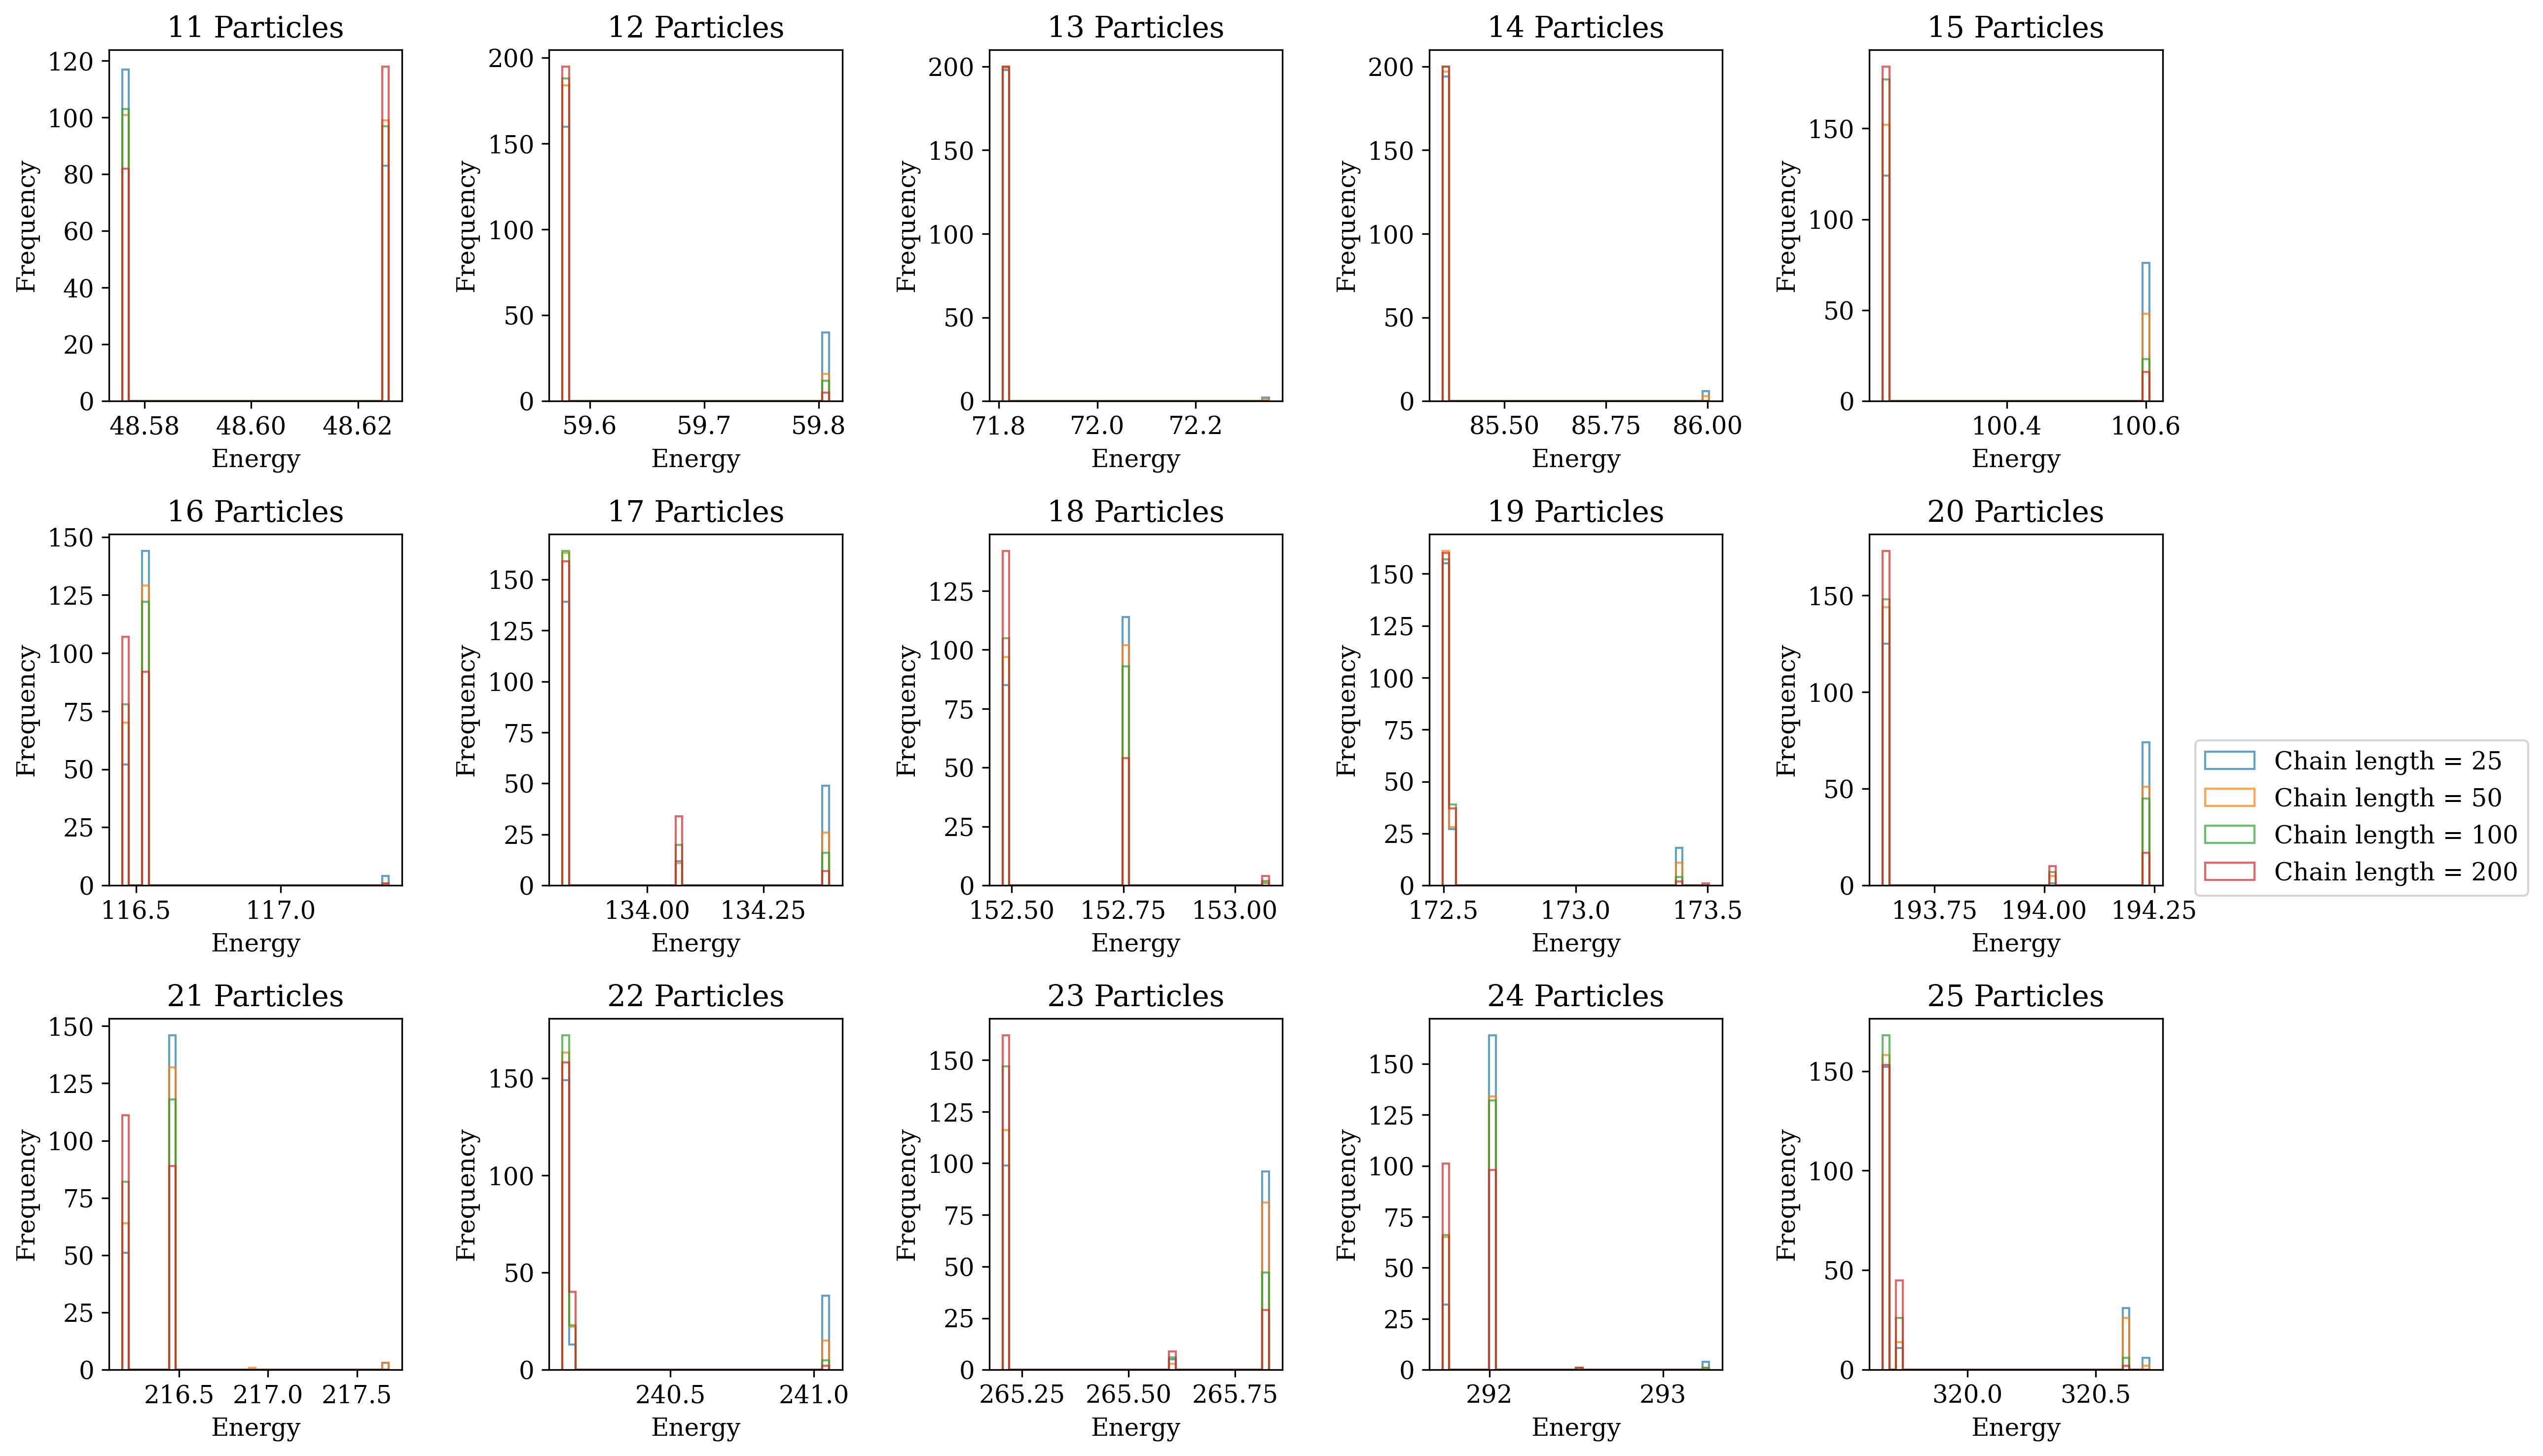

In [91]:
colors = sns.color_palette('tab10', len(markov_chain_names)) 
nrows = 3 
ncols = 5  
x = 0
y = 0
loc = 0

markov_names = ['Chain length = 25', 'Chain length = 50', 'Chain length = 100', 'Chain length = 200']

fig, ax = plt.subplots(nrows, ncols,figsize=(15, 10), dpi=300)
for count in range(11,26):  
    for i, metric in enumerate(markov_chain_names):
        # Plot histogram with customized bins and only outlines
        if count == 11:
            ax[y][x].hist(MC_data[count][metric], bins=MC_data[count]['bins'], alpha=0.7, color=colors[i], label=markov_names[i], histtype='step')
        else:
            ax[y][x].hist(MC_data[count][metric], bins=MC_data[count]['bins'], alpha=0.7, color=colors[i], histtype='step')
        ax[y][x].set_title(f"{count} Particles")
        ax[y][x].set_xlabel('Energy')
        ax[y][x].set_ylabel('Frequency')
    
    # placement in grid
    loc +=1
    if loc%5 == 0:
        x = 0
        y+=1
    else: 
        x+=1

fig.legend(bbox_to_anchor=[1.15,0.5])
fig.tight_layout()

### Data Neighboring procedures

In [17]:
# Parameters
circle_radius = 1
markov_chain = 100
simulation_steps = 50 * markov_chain
initial_step_size = 1
final_step_size = 0.02
final_temperature = 0.001

alphas = [1.0 ,1.0, 0.5, 0.1, 0.0]
betas = [0.0, 0.1, 0.5, 1.0, 1.0]

for alpha,beta in zip(alphas,betas):
    # List to collect results metadata
    results_metadata = []
    # Create an HDF5 file

    with h5py.File(f'simulation_results_{cooling_schedule}.hdf5', 'w') as hdf_file:
        # Iterate over the specified number of particles
        for i, n_particles in enumerate(range(11, 27)):
            print(f"Running simulation for {alpha}-{beta}/{n_particles} particles...")
            initial_temperature = 20 * n_particles

            for simulation in range(200):  # 100 simulations per particle count
                
                annealing_particles, annealing_min_energy, annealing_energy_over_time, step_sizes, acceptance_rates = simulate_charged_particles_individual_steps(
                n_particles, circle_radius, simulation_steps, initial_step_size, final_step_size, initial_temperature, final_temperature, markov_chain=markov_chain, alpha=alpha, beta=beta
            )
                # Save particle positions to HDF5
                dataset_name = f'Particles_{n_particles}_Sim_{simulation}'
                hdf_file.create_dataset(dataset_name, data=np.array(annealing_particles))

                # Collect metadata
                results_metadata.append({
                    'Particle_Count': n_particles,
                    'Simulation_Number': simulation,
                    'Min_Energy': annealing_min_energy,
                    'Positions_Dataset': dataset_name,
                    'Energy_Over_Time': annealing_energy_over_time,
                    'step_sizes': step_sizes,
                    'acceptance_rates': acceptance_rates  # Convert to list for storage
                })

    # Create DataFrame from metadata and save to CSV
    metadata_df = pd.DataFrame(results_metadata)
    metadata_df.to_csv(f'simulation_metadata_{alpha}-{beta}.csv', index=False)



Running simulation for 1-0/11 particles...
Running simulation for 1-0/12 particles...
Running simulation for 1-0/13 particles...
Running simulation for 1-0/14 particles...
Running simulation for 1-0/15 particles...
Running simulation for 1-0/16 particles...
Running simulation for 1-0/17 particles...
Running simulation for 1-0/18 particles...
Running simulation for 1-0/19 particles...
Running simulation for 1-0/20 particles...
Running simulation for 1-0/21 particles...
Running simulation for 1-0/22 particles...
Running simulation for 1-0/23 particles...
Running simulation for 1-0/24 particles...
Running simulation for 1-0/25 particles...
Running simulation for 1-0/26 particles...
Running simulation for 1-0.1/11 particles...
Running simulation for 1-0.1/12 particles...
Running simulation for 1-0.1/13 particles...
Running simulation for 1-0.1/14 particles...
Running simulation for 1-0.1/15 particles...
Running simulation for 1-0.1/16 particles...
Running simulation for 1-0.1/17 particles.

In [49]:
neighbor_names = ['0-1','0.1-1','0.5-0.5','1-0.1', '1-0']

neighbor_data = process_data(neighbor_names)

11
12
13
14
15
16
17
18
19
20
21
22
23
24
25


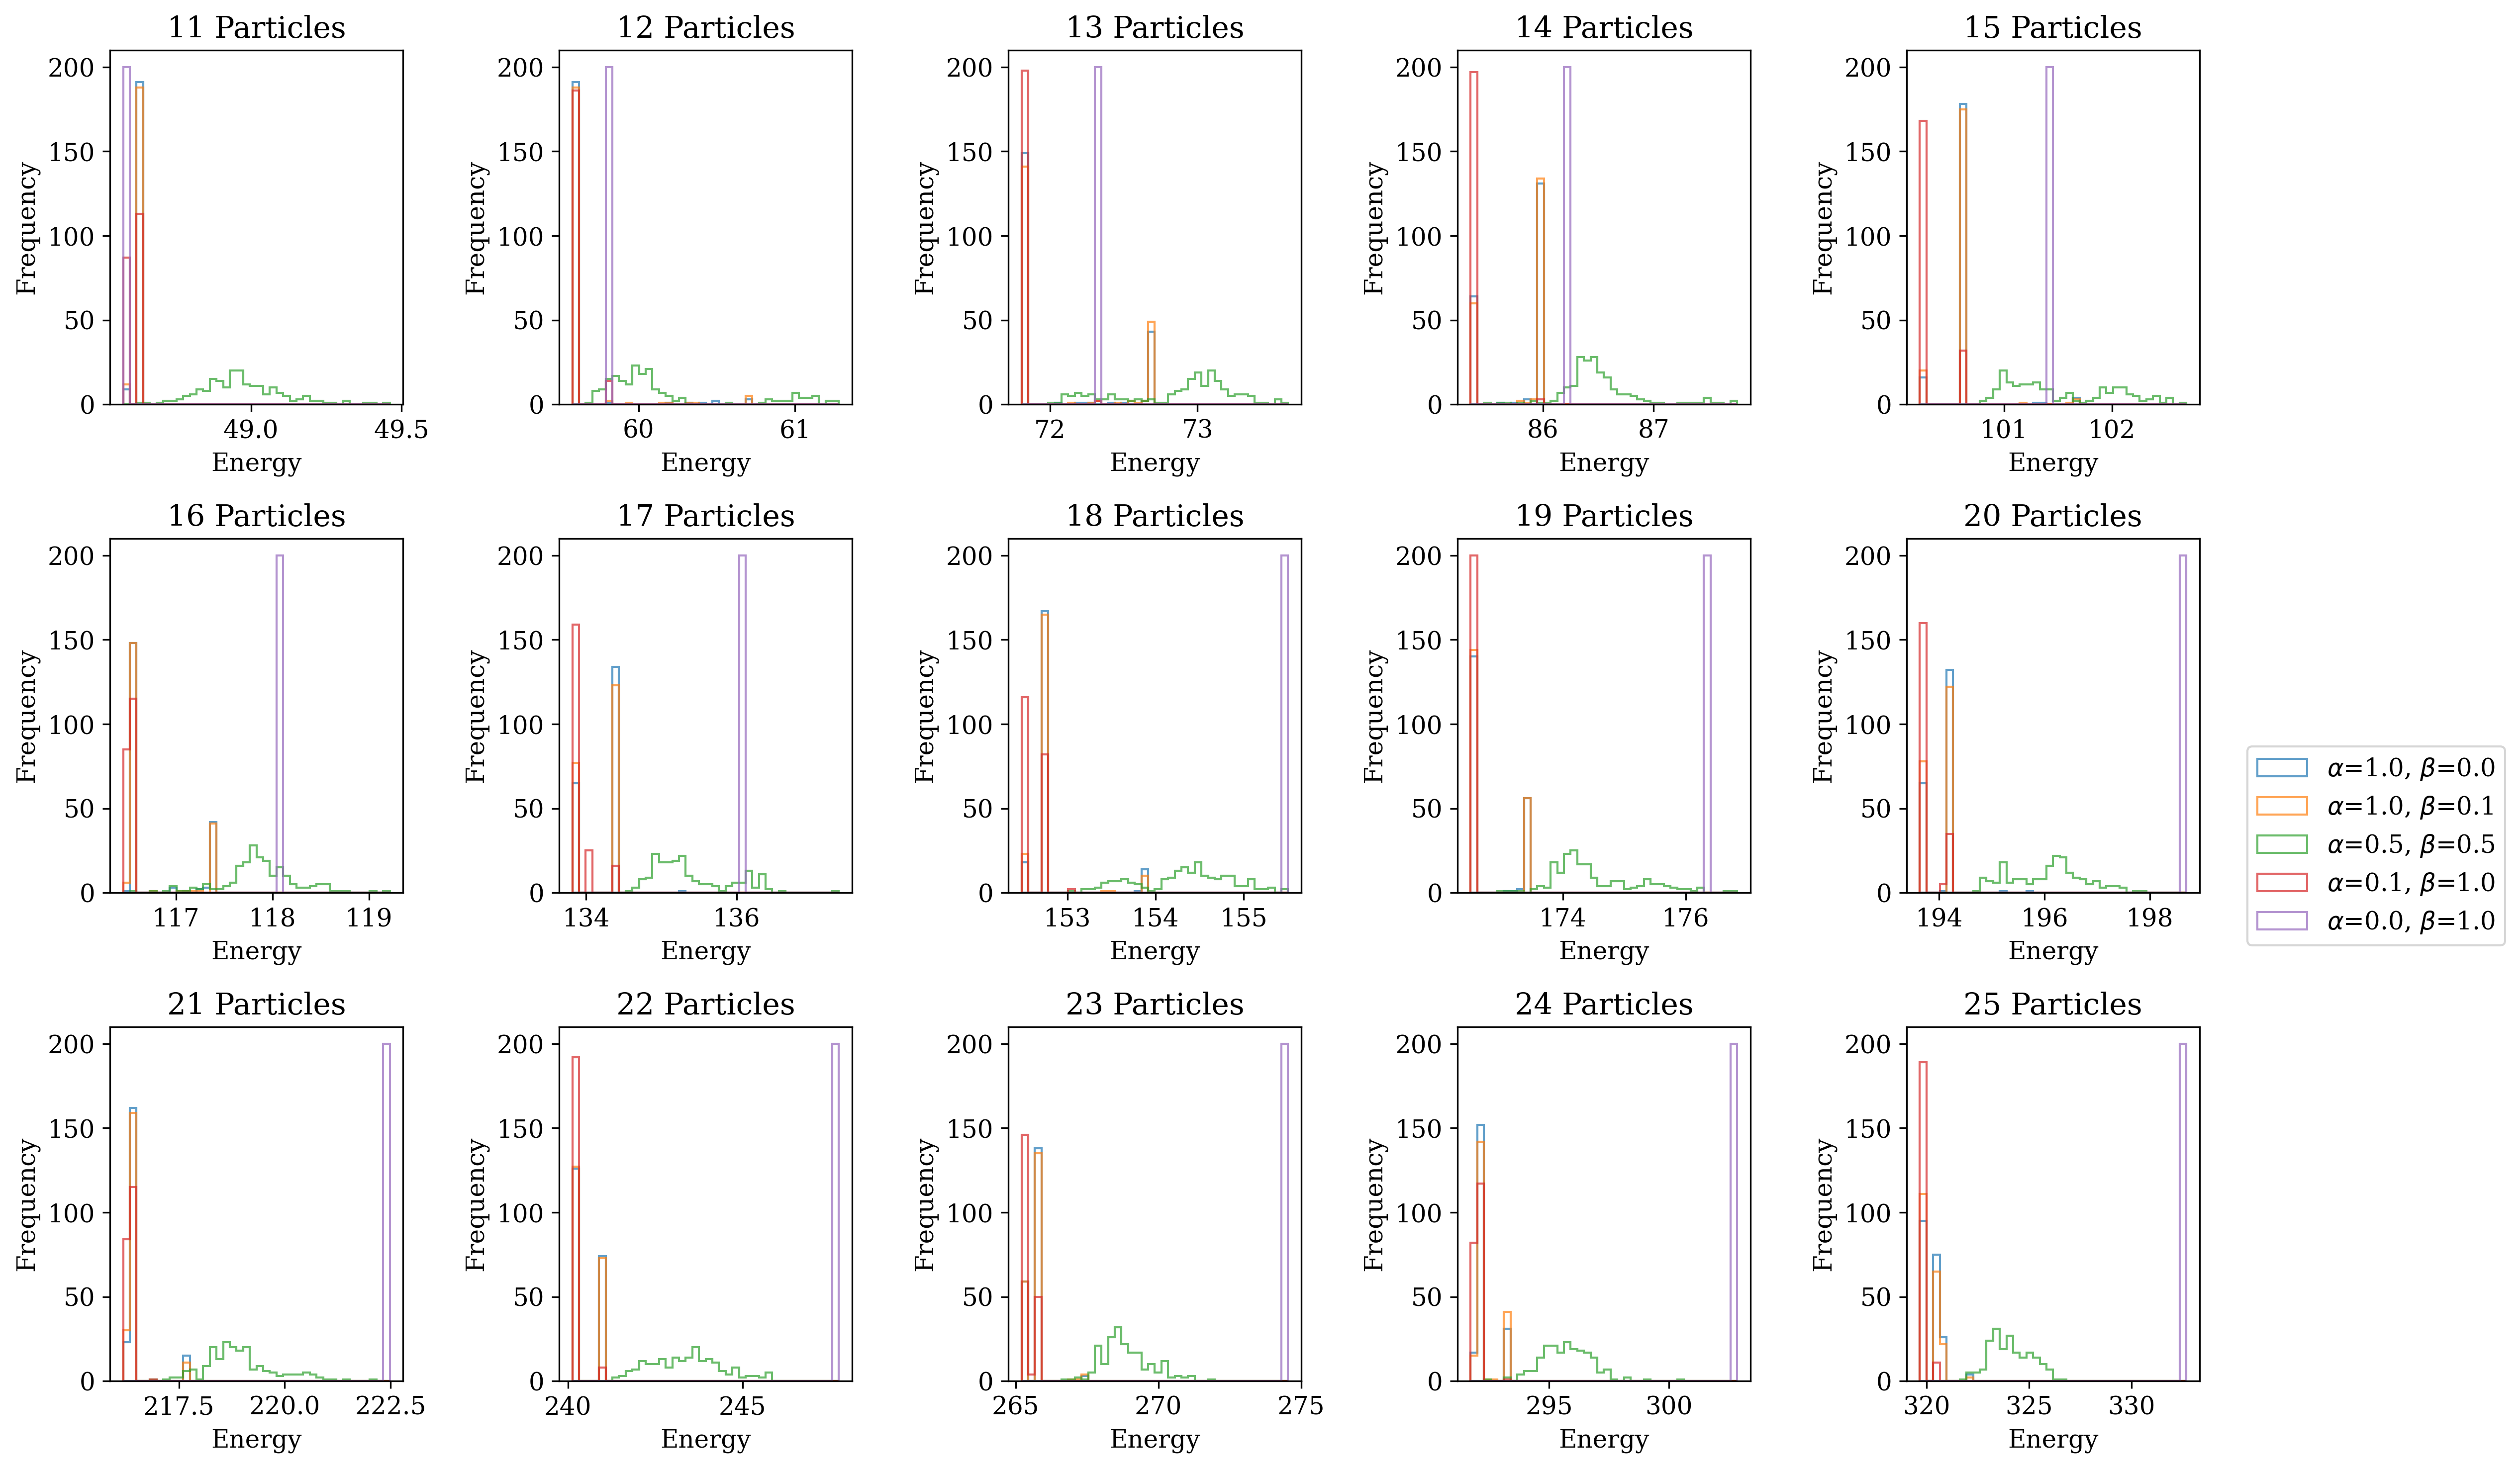

In [100]:
colors = sns.color_palette('tab10', len(neighbor_names))  
nrows = 3 
ncols = 5  
x = 0
y = 0
loc = 0

fig, ax = plt.subplots(nrows, ncols,figsize=(15, 10), dpi=300)
for count in range(11,26):  
    for i, metric in enumerate(neighbor_names):
        # Plot histogram with customized bins and only outlines
        if count == 11:
            ax[y][x].hist(neighbor_data[count][metric], bins=neighbor_data[count]['bins'], alpha=0.7, color=colors[i], label=r'$\alpha$='f'{alphas[i]}, 'r'$\beta$='f'{betas[i]}', histtype='step')
        else:
            ax[y][x].hist(neighbor_data[count][metric], bins=neighbor_data[count]['bins'], alpha=0.7, color=colors[i], histtype='step')
        ax[y][x].set_title(f"{count} Particles")
        ax[y][x].set_xlabel('Energy')
        ax[y][x].set_ylabel('Frequency')
    
    # placement in grid
    loc +=1
    if loc%5 == 0:
        x = 0
        y+=1
    else: 
        x+=1

fig.legend(bbox_to_anchor=[1.13,0.5])
fig.tight_layout()